<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Levelized-Cost-of-Driving-Calculator" data-toc-modified-id="Levelized-Cost-of-Driving-Calculator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Levelized Cost of Driving Calculator</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Setting-Inputs" data-toc-modified-id="Setting-Inputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setting Inputs</a></span></li></ul></div>

<h2>Levelized Cost of Driving Calculator</h2>

The Purpose of this tool is to compare the levelized cost of driving (LCOD) for various types of vehilces based on assumptions made in the report *Canada's Energy Future 2018* published by the National Energy Board (NEB). LCOD is calculated by taking a number of variables into account including; the purchase price of a vehicle, fuel costs, the discount rate, and the expected life of the vehicle.

Below is the script which pulls the data needed to make these calculations. Purchase and fuel cost data is taken from the NEB, while annual up keep cost assumptions are based on journal articles. 

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout, Box
from textwrap import wrap

#Set current year
now = dt.datetime.now()
cur_year = now.year

#Import electricity data and gasoline data from EF, saved to local drive
end_use_data = pd.read_excel('C:\\Users\\saftryan\\English End Use Prices.xlsx') #Remap to local folder
elc_data = end_use_data[(end_use_data.Variable_English == 'Electricity') & (end_use_data.Sector == 'Residential') & (end_use_data.Case != 'High Price') & (end_use_data.Case != 'Low Price')]
elc_data['$/unit'] = elc_data['Value']/277.778
elc_data['Variable_English'] = 'B'
reg_gas = end_use_data[(end_use_data.Variable_English == 'Gasoline') & (end_use_data.Sector == 'Transportation') & (end_use_data.Case != 'High Price') & (end_use_data.Case != 'Low Price')]
reg_gas['$/unit'] = reg_gas['Value']*34.66/1000
reg_gas['Variable_English'] = 'X'
prm_gas = reg_gas.copy()
prm_gas['$/unit'] = prm_gas['$/unit']*1.1
prm_gas['Variable_English'] = 'Z'
diesel = end_use_data[(end_use_data.Variable_English == 'Diesel') & (end_use_data.Sector == 'Transportation') & (end_use_data.Case != 'High Price') & (end_use_data.Case != 'Low Price')]
diesel['$/unit'] = diesel['Value']*38.68/1000
diesel['Variable_English'] ='D'
neb_fuel = reg_gas.append(prm_gas)
neb_fuel = neb_fuel.append(diesel)
neb_fuel = neb_fuel.append(elc_data)

#Vehicle Costs
all_ice_cost = pd.DataFrame(data={'ice': ['COMPACT','FULL-SIZE','MID-SIZE','MINICOMPACT','MINIVAN','PICKUP TRUCK - SMALL','PICKUP TRUCK - STANDARD','STATION WAGON - MID-SIZE','STATION WAGON - SMALL','SUBCOMPACT','SUV - SMALL','SUV - STANDARD','TWO-SEATER'],
                                  'cost': [19500,32000,24000,34000,31000,26000,34000,49000,21000,39000,29000,45000,100000]})
all_ev_cost = pd.DataFrame(data={'ev': ['BMW i3','BOLT','FOCUS','IONIQ','LEAF','FORTWO','MODEL 3','MODEL S','MODEL X','GOLF'],
                                 'cost': [45500, 36600, 30000, 37500, 36800, 27400, 60100, 101300, 116000, 36400]})
ef_costs = pd.read_excel('C:\\Users\\saftryan\\LCOD stuff\\EF Veh Costs.xlsx')

<h2>Functions</h2>

- **sets:** creates a list of based on all of the unque values in a column
- **LCOD_calc:** calculates the Levilized Cost of Driving using the formula:


$$ LCOD = \frac {CRF * CC + M} {km/yr} + \frac {CAD/Unit}{Eff}$$

Where: 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CC = Capital cost of the vehicle
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I = Infrastructure investment (e.g. Charging station for EV) 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;M = Annual maintenance cost of the vehicle 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;km/yr = expected kilometers driver per year 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CAD/Unit = Cost of one unit of fuel (kwh or l of gasoline) 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Eff = Fuel efficency of vehicle in l or kw per km 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CRF = Capital Recovery Factor

$$ CRF = \frac {r*(1+r)^t} {(1+r)^t-1} $$

Where: 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;r = Discount rate 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;t = Time period

- **eff_gains:** projects future improvements in fuel economy using the formula:

$$ Eff_i = Eff_0*(1-Imp)^{(t_i - t_0)} $$
Where:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Eff = Fuel efficency of vehicle in liters of gasoline or kilowatts of electricity per kilometer 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;t = Time period



In [2]:
#Create a list of names
def sets (data):
    name_set=[]
    for name in data:
        if name not in name_set:
            name_set.append(name)
    return name_set

#Calculate LCOD
def lcod_calc (cap_cost, main, fuel_cost, fuel_eff):
    fuel_eff1=np.where((single_fuel['veh']=='ice_truck') | (single_fuel['veh']=='ev_truck'),fuel_eff*1.5,fuel_eff)
    main1=np.where((single_fuel['veh']=='ice_truck') | (single_fuel['veh']=='ev_truck'),main*1.5,main)
    lcod = (crf*(cap_cost+I)+main1)/kmyr + fuel_cost/(1/(fuel_eff1/100))
    return lcod

#Calcualte the annual improvement in chenicle efficency
def eff_gains (start_eff, impv):
    eff_proj = pd.DataFrame(data = {'Year': range(2020,2041), 'improve_time': range(1,22)})
    eff_proj['eff'] = start_eff*(1-impv)**(eff_proj['Year']-2020)
    return eff_proj

def f (z):
    return z

In [3]:
prov_names = sets(neb_fuel['Region']) 
prov_names.sort()
rgnsel = interactive(f, z=widgets.Dropdown(options=prov_names, description='Region', value='Canada'));
infYN = interactive(f, z=widgets.Dropdown(options=['Add EV Charging Station','No EV Charging Station'],
                                          description='Charging', value='No EV Charging Station'));

<h2>Setting Inputs</h2>

The following cell contains variables that can be manipulated by the user, although it is not necessary to make any changes. They are defined below:

- **r:** Discount rate, can be set to any value between 0 and 1. A higher number means less value will be placed on future expenses

- **t:** The expected life of the vehicle in years

- **kmyr:** Enter number of km per year you expect drive

- **user_car_cost:** If you want to specify a price in Canadian dollars for the ICE vehicle enter it here, otherwise a class average will be used

- **user_ev_cost:** If you want to specify a price in Canadian dollars for the EV vehicle enter it here, otherwise the cost of the base model will be used

- **ice_main:** Specify annual amount you expect to pay in  maintenance for an ICE vehicle in Canadian dollars. If unknown leave as default.

- **ev_main:** Specify annual amount you expect to pay in Canadian dollars maintenance for an EV in Canadian dollars. If unknown leave as default. 

- **ev_eff_2020:** The efficency at which an EV uses electricty while driving in 2020, measured in kwh/km

- **ice_ann_impv:** Rate of annual improvement in EV efficency. A value of 0.02 % means efficency improves by 2% each year

- **ice_eff_2020:** The efficency at which an ICE vehicle uses gasolin while driving in 2020, measured in l/km of gasoline

- **ice_ann_impv:** Rate of annual improvement in ICE vehicle efficency. A value of 0.02 % means efficency improves by 2% each year


After defining variables run the cell below.

In [4]:
r=0.10
t=15
kmyr=15000
ice_main = 530
ev_main = 450
ev_eff_2020 = 20 
ev_ann_impv = 0.02
ice_eff_2020 = 7
ice_ann_impv = 0.01

#Calculate CRF based on inputs
crf = (r*(1+r)**t)/((1+r)**t-1)

#Select the region you wish to run the comparison for
display(rgnsel)
display(infYN)

interactive(children=(Dropdown(description='Region', index=2, options=('Alberta', 'British Columbia', 'Canada'…

interactive(children=(Dropdown(description='Charging', index=1, options=('Add EV Charging Station', 'No EV Cha…

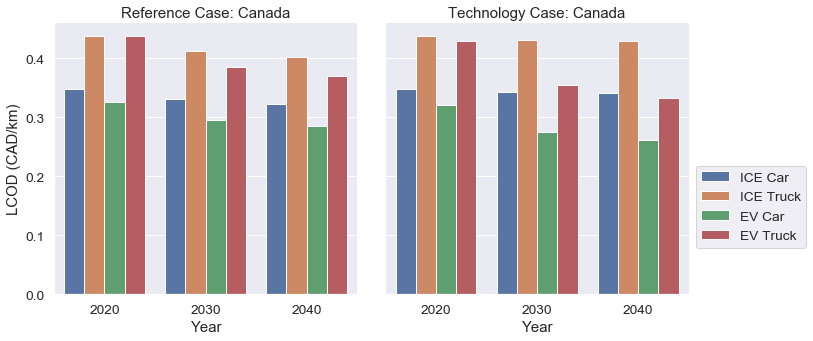

In [5]:
#Create list of province names
region = rgnsel.result
if infYN.result == 'Add EV Charging Station':
    I = 1000
else:
    I = 0

ev_eff_proj = eff_gains(ev_eff_2020, ev_ann_impv)
ev_eff_proj['Variable_English'] = 'B'
ice_eff_proj = eff_gains(ice_eff_2020, ice_ann_impv)
ice_eff_proj['Variable_English'] = 'X'
veh_eff_proj = ev_eff_proj.append(ice_eff_proj)

eff_merged = ef_costs.merge(neb_fuel, on=['Year', 'Variable_English', 'Case'])
eff_merged = eff_merged.merge(veh_eff_proj, on=['Year', 'Variable_English'])

fuel_type_list = sets(eff_merged['Variable_English'])

eff_lcod=[]
for fuel_type in (fuel_type_list):
    if fuel_type == 'X':
        main = ice_main
    else:
        main = ev_main
    single_fuel = eff_merged[(eff_merged.Variable_English == fuel_type)]
    single_fuel['LCOD'] = lcod_calc(single_fuel['price'], main, single_fuel['$/unit'], single_fuel['eff'])
    eff_lcod.append(single_fuel)
veh_eff = pd.concat(eff_lcod)

#The line below can be activeate and the directory can be changed if you want to export the LCOD data to a csv file 
#veh_eff.to_csv('C:\\Users\\saftryan\\LCOD stuff\\lcod.csv')
rgn_plt = veh_eff[veh_eff.Region == region]
#Plot Charts
sns.set(font_scale=1.25,)
g=sns.catplot(x='Year',y='LCOD',hue='veh',data=rgn_plt, kind='bar',col='Case',ci=None, legend=False,
             row_order=['ice_car','ev_car', 'ice_truck','ev_truck'])
plt.legend(loc=0, labels = ['ICE Car', 'ICE Truck', 'EV Car', 'EV Truck'], bbox_to_anchor=(1,.5))
g.set_titles('{col_name} Case: '+ region)
g.set_axis_labels('Year','LCOD (CAD/km)')

In [15]:
single_fuel

,Year,price,veh,Variable_English,Case,Region,Value,Sector,$/unit,improve_time,eff,LCOD
168,2020,30660,ev_car,B,Reference,Ontario,60.894516,Residential,0.219220,1,20.000000,0.342576
169,2020,30660,ev_car,B,Reference,Quebec,26.114114,Residential,0.094011,1,20.000000,0.317535
170,2020,30660,ev_car,B,Reference,British Columbia,31.987569,Residential,0.115155,1,20.000000,0.321763
171,2020,30660,ev_car,B,Reference,Alberta,32.515704,Residential,0.117056,1,20.000000,0.322144
172,2020,30660,ev_car,B,Reference,Manitoba,28.235011,Residential,0.101646,1,20.000000,0.319062
173,2020,30660,ev_car,B,Reference,Saskatchewan,51.840601,Residential,0.186626,1,20.000000,0.336058
174,2020,30660,ev_car,B,Reference,New Brunswick,44.473508,Residential,0.160105,1,20.000000,0.330753
175,2020,30660,ev_car,B,Reference,Nova Scotia,49.305163,Residential,0.177498,1,20.000000,0.334232
176,2020,30660,ev_car,B,Reference,Newfoundland and Labrador,45.236151,Residential,0.162850,1,20.000000,0.331302
177,2020,30660,ev_car,B,Reference,Prince Edward Island,55.517189,Residential,0.199862,1,20.000000,0.338705


The above charts show the projected LCOD in the region selected earlier based off of the vehicle cost assumptions made in the report *Canada's Energy Future 2018*.

The next section compares the difference in LCOD between an ICE and an EV in the Reference and Tecnology cases for the same sized vehicles (e.g. ICE Car vs EV Car) based off of the assumptions made in the previous section. To display charts showing these results run the cell below.

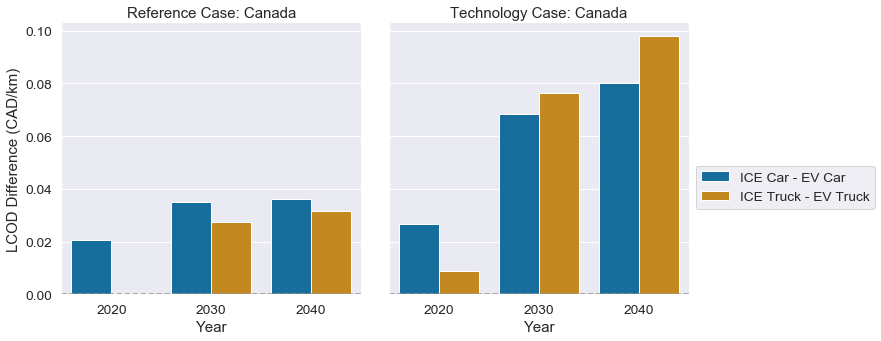

In [6]:
ice_lcod = eff_lcod[0]
ev_lcod = eff_lcod[1]
ev_lcod = ev_lcod.reset_index(drop=True)
ice_lcod['ev_lcod'] = ev_lcod['LCOD']
ice_lcod['comp_type'] = ice_lcod['veh'] + '-' + ev_lcod['veh']
ice_lcod['ice_less_ev'] = ice_lcod['LCOD'] - ice_lcod['ev_lcod']
comp_list = sets(ice_lcod['comp_type'])
rgn_plt = ice_lcod[ice_lcod.Region == region]

sns.set(font_scale=1.25)
g=sns.catplot(x='Year',y='ice_less_ev',hue='comp_type',data=rgn_plt,
              kind='bar',col='Case',ci=None, legend=False, palette='colorblind')
g.set_axis_labels('Year','LCOD Difference (CAD/km)')
g.set_titles('{col_name} Case: '+ region)
ax1, ax2 = g.axes[0]
plt.legend(loc=0, labels = ['ICE Car - EV Car', 'ICE Truck - EV Truck'], bbox_to_anchor=(1,.5))
ax1.axhline(0, ls='--', color='grey')
ax2.axhline(0, ls='--', color='grey')

These charts show the difference in LCOD between ICE vehicles and EVs based off of the assumptions made earlier in the report. A positive number indicates that the electric version of either the car or truck has a lower LCOD than that of its ICE equivilant, meaning that is cheaper to drive on a per km basis. The point where EVs become cheaper than ICE vehicles will vary based on the imputs.

In [249]:
#The lines below can be activeate and the directory can be changed if you want to export the LCOD data to a csv file 
veh_eff.to_csv('C:\\Users\\saftryan\\LCOD stuff\\lcod1.csv')
ice_lcod.to_csv('C:\\Users\\saftryan\\LCOD stuff\\lcod_comp1.csv')